### Time Frequency Representations

In [1]:
import torch
from data import EEGDataset, normalize, stackplot
from dynaconf import settings

In [23]:
train_dataset_csv = settings.TRAIN_DATASET_CSV
dev_dataset_csv = settings.DEV_DATASET_CSV
length = 2000
select_channels = settings.SELECT_CHANNELS

dataset = EEGDataset(train_dataset_csv, length, select_channels, max_num_examples=500, transform=normalize)

Found 2765 recordings
By set limit only using 500 recordings
Removing recordings of insufficient length...
Removed 5 of 500 recordings. There are now 495 recordings.


#### Spectrograms 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html

In [7]:
%matplotlib inline
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import numpy as np

In [8]:
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

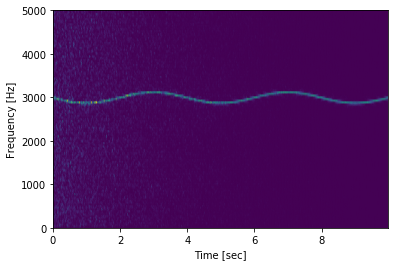

In [9]:
f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

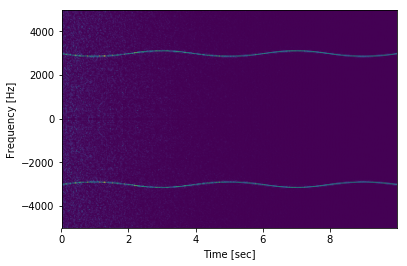

In [10]:
f, t, Sxx = signal.spectrogram(x, fs, return_onesided=False)
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

#### With EEGs

In [24]:
import random

In [71]:
sample = dataset[random.randint(0, len(dataset))].squeeze()

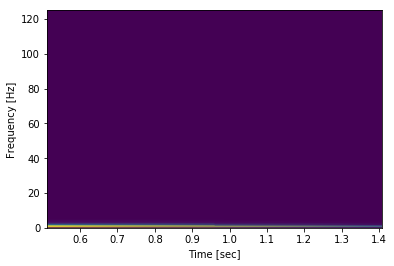

In [73]:

f, t, Sxx = signal.spectrogram(sample[:500], 250)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [114]:
# from Siyi
from scipy.fftpack import fft, diff
def computeTimeFreqRep(signals, freq = 12, overlap = 0.25, window = 1):
    """
    Args:
        signals: EEG segment, shape (number of channels, number of data points)
        freq: sampling frequency in Hz
        overlap: proportion of overlap with previous segment
        window: window size in seconds
    Returns:
        S: time-frequency representation, shape (number of channels, number of data points)
        where number of data points depends on freq, overlap and window.
    """
    n_ch, t_len = signals.shape

    start_time = 0
    end_time = min(t_len, start_time + int(freq * window))
      
    signal_segs = [signals[:,start_time:end_time]]

    while end_time < t_len:        
        offset = int(freq * window * overlap)
        start_time = end_time - offset
        end_time = min(t_len, start_time + int(freq * window))
        curr_seg = signals[:, start_time:end_time]
        if curr_seg.shape[1] < int(freq * window):
            diff = int(freq * window) - curr_seg.shape[1]
            curr_seg = np.concatenate((curr_seg, np.zeros((n_ch, diff))), axis=1)
        signal_segs.append(curr_seg)
    
    signal_segs = np.concatenate(signal_segs, axis=1)
    
    # FFT
    S = computeFFT(signal_segs)

    return S


def computeFFT(signals):
    """
    Args:
        signals: EEG signals, (number of channels, number of data points)
    Returns:
        S: FFT of signals, (number of channels, number of data points)
    """
    N = signals.shape[1]

    # fourier transform
    fourier_signal = fft(signals, axis=1)
    
    S = 1.0/N * np.abs(fourier_signal)
    
    return S

In [111]:
tfr = computeTimeFreqRep(sample[:100].unsqueeze(0), freq=250)

(1, 100)


In [112]:
tfr.shape

(1, 100)

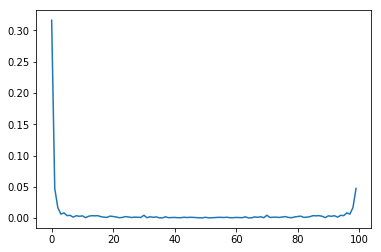

In [113]:
plt.plot(np.squeeze(tfr))

In [186]:
def convert_to_tfr(signals, window_size, freq=250):
    """
    Args:
        signals: EEG segment, shape (num_channels, number of data points)
        window: window size in datapoints 
        freq: sampling frequency in Hz
    Returns:
        S: time-frequency representation, shape (number of channels, number of data points, c)
        where number of data points depends on window.
    """
    if len(signals.shape) == 1:
        signals = signals.unsqueeze(0)
    length = singals.shape[1]
    assert(window_size < length)
    num_segments = length // window_size
    segments = []
    for i in range(num_segments):
        tfr = computeTimeFreqRep(signals[:, i*window_size: (i+1)*window_size])
        segments.append(torch.from_numpy(tfr))
    print(segments[0].shape)
    segments = torch.stack(segments, dim=0)
    segments = segments.transpose(1, 0) 
    return segments    

In [187]:
signals = sample[:400].unsqueeze(0).view(4, 100)

In [188]:
singals.shape

torch.Size([1, 100])

In [189]:
convert_to_tfr(signals, 20).shape

torch.Size([4, 24])


torch.Size([4, 5, 24])